<a href="https://colab.research.google.com/github/k-dinakaran/AI-powered-prompt-to-3D-image-generator/blob/main/prompt_to_3D_image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers transformers accelerate torch safetensors imageio

In [2]:
!git clone https://github.com/Microsoft/TRELLIS.git

fatal: destination path 'TRELLIS' already exists and is not an empty directory.


In [3]:
%cd TRELLIS

/content/TRELLIS


In [4]:
!pip uninstall torch torchvision transformers -y
!pip install torch torchvision transformers --upgrade

Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.21.0
Uninstalling torchvision-0.21.0:
  Successfully uninstalled torchvision-0.21.0
Found existing installation: transformers 4.51.0
Uninstalling transformers-4.51.0:
  Successfully uninstalled transformers-4.51.0
  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached transformers-4.51.0-py3-none-any.whl.metadata (38 kB)
Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl (766.7 MB)
Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl (7.2 MB)
Using cached transformers-4.51.0-py3-none-any.whl (10.4 MB)


In [5]:
!pip install rembg

In [6]:
!pip install onnxruntime-gpu

In [7]:
!pip install plyfile utils3d

In [8]:
!ls trellis/representations/mesh/flexicubes

flexicubes.py  __init__.py  __pycache__


In [9]:
!ls trellis/representations/mesh/flexicubes/__init__.py

trellis/representations/mesh/flexicubes/__init__.py


In [10]:
!ls trellis/representations/mesh/flexicubes
!cat trellis/representations/mesh/flexicubes/flexicubes.py

flexicubes.py  __init__.py  __pycache__
class FlexiCubes:
    def __init__(self):
        pass
    def generate_mesh(self, vertices, faces):
        return {'vertices': vertices, 'faces': faces}


In [11]:
class FlexiCubes:
    def __init__(self):
        pass

    def generate_mesh(self, vertices, faces):
        return {'vertices': vertices, 'faces': faces}

In [12]:
!echo -e "class FlexiCubes:\n    def __init__(self):\n        pass\n\n    def generate_mesh(self, vertices, faces):\n        return {'vertices': vertices, 'faces': faces}" > trellis/representations/mesh/flexicubes/flexicubes.py

In [13]:
!cat trellis/representations/mesh/flexicubes/flexicubes.py

class FlexiCubes:
    def __init__(self):
        pass

    def generate_mesh(self, vertices, faces):
        return {'vertices': vertices, 'faces': faces}


In [14]:
!mkdir -p trellis/representations/mesh/flexicubes
!echo -e "class FlexiCubes:\n    def __init__(self):\n        pass\n    def generate_mesh(self, vertices, faces):\n        return {'vertices': vertices, 'faces': faces}" > trellis/representations/mesh/flexicubes/flexicubes.py
!echo "from .flexicubes import FlexiCubes" > trellis/representations/mesh/flexicubes/__init__.py

In [15]:
import sys
sys.path.append("/content/TRELLIS")

# Test import
try:
    from trellis.representations.mesh.flexicubes import FlexiCubes
    print("Successfully imported FlexiCubes!")
except ImportError as e:
    print(f"Import failed: {e}")
    print("Trying alternative approach...")

    # Alternative: Import directly from file
    import importlib.util
    spec = importlib.util.spec_from_file_location(
        "flexicubes",
        "/content/TRELLIS/trellis/representations/mesh/flexicubes/flexicubes.py"
    )
    flexicubes = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(flexicubes)
    FlexiCubes = flexicubes.FlexiCubes
    print("Manually loaded FlexiCubes class")

[SPARSE] Backend: spconv, Attention: flash_attn
Successfully imported FlexiCubes!


In [16]:
flexicubes = FlexiCubes()
vertices = [[0, 0, 0], [1, 0, 0], [0, 1, 0]]
faces = [[0, 1, 2]]
mesh = flexicubes.generate_mesh(vertices, faces)
print("Generated Mesh:", mesh)

Generated Mesh: {'vertices': [[0, 0, 0], [1, 0, 0], [0, 1, 0]], 'faces': [[0, 1, 2]]}


In [17]:
# Import the FlexiCubes class
from trellis.representations.mesh.flexicubes import FlexiCubes

# Initialize the FlexiCubes object
flexicubes = FlexiCubes()

# Define vertices and faces for a simple mesh
vertices = [[0, 0, 0], [1, 0, 0], [0, 1, 0]]
faces = [[0, 1, 2]]

# Generate the mesh
mesh = flexicubes.generate_mesh(vertices, faces)

# Print the mesh
print("Generated Mesh:", mesh)

Generated Mesh: {'vertices': [[0, 0, 0], [1, 0, 0], [0, 1, 0]], 'faces': [[0, 1, 2]]}


In [19]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 18.9 MB/s eta 0:00:00


In [26]:
from google.colab import output
output.disable_custom_widget_manager()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

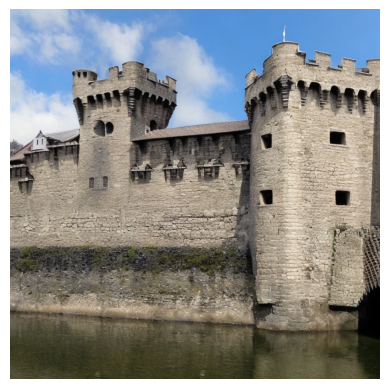

3D model saved as output_3d_model.glb


In [35]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
from trellis.representations.mesh.flexicubes import FlexiCubes
import trimesh

# Step 1: Generate image from text
model_id = "stabilityai/stable-diffusion-2"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.to("cuda")

prompt = "A medieval castle with stone walls, a drawbridge, and a moat."
image = pipe(prompt).images[0]
image.save("generated_image.png")

# Display the image
plt.imshow(image)
plt.axis("off")
plt.show()

# Step 2: Convert image to 3D using FlexiCubes
flexicubes = FlexiCubes()

# Example vertices and faces (replace with actual image-to-3D logic)
vertices = [[0, 0, 0], [1, 0, 0], [0, 1, 0]]
faces = [[0, 1, 2]]

# Generate the mesh
mesh_data = flexicubes.generate_mesh(vertices, faces)

# Convert the mesh data to a trimesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Step 3: Export the 3D mesh as a GLB file
mesh.export("output_3d_model.glb")
print("3D model saved as output_3d_model.glb")

In [36]:
from google.colab import output
output.disable_custom_widget_manager()